## **Canny's Edge Detector** 

In [0]:
import numpy as np
from math import *
from PIL import Image
from copy import deepcopy
from scipy.misc import imsave
from matplotlib import pyplot as plt


Step 1: Conversion of image to numpy matrix

In [0]:
def get_image_pixels(image1):
  im = Image.open(image1)
  input_img = np.matrix(im)
  return input_img


Step 2: To obtain the Gaussian Mask and convert it into numpy matrix

In [0]:
def get_gaussian_mask():
  gaussian_mask = [[1,1,2,2,2,1,1],[1,2,2,4,2,2,1],[2,2,4,8,4,2,2],[2,4,8,16,8,4,2],[2,2,4,8,4,2,2],[1,2,2,4,2,2,1],[1,1,2,2,2,1,1]]
  gaussian_mask = np.matrix(gaussian_mask)
  return gaussian_mask


Step 3: Performing Gaussian smoothing on the input image using the Gaussian mask and then normalizing by dividing by the sum of elements in Gaussian mask (140)

In [0]:
def gaussian_smoothing(input_img,gaussian_mask,n,m):
  output1 = [[0 for j in range(m)] for i in range(n)]
  gaussian_sum = gaussian_mask.sum()
  for i in range(3,n-3):                  #The values of 3 pixels from each boundary is undefined
      for j in range(3,m-3):              
        output1[i][j] = np.multiply(input_img[i-3:i+4,j-3:j+4],gaussian_mask).sum()
  output1 = np.matrix(output1)
  output1 = output1*1.0/gaussian_sum
  return output1

Step 4: Obtaining the horizontal (Gx) and vertical (Gy) gradients of the Gaussian-smoothed image using the Prewitt's operator. Then normalize both the gradient matrices by dividing by 3

In [0]:
def get_XY_gradients(output1,Gx_mask,Gy_mask,n,m):

  Gx = [[0 for j in range(m)] for i in range(n)]
  Gy = [[0 for j in range(m)] for i in range(n)]

  for i in range(4,n-4):            #The values of 4 pixels from each boundary is undefined
      for j in range(4,m-4):
        Gx[i][j] = abs(np.multiply(output1[i-1:i+2,j-1:j+2],Gx_mask).sum())
        Gy[i][j] = abs(np.multiply(output1[i-1:i+2,j-1:j+2],Gy_mask).sum())


  Gx = np.matrix(Gx)
  Gy = np.matrix(Gy)
  Gx = Gx/3
  Gy = Gy/3

  return [Gx,Gy]


Step 5 : From the horizontal (Gx) and vertical (Gy) gradients, obtain the gradient magnitude matrix (M) and gradient angle matrix (Theta).
Further, the gradient magnitude matrix(M) is normalized by dividing by square root of 2.

In [0]:
def get_gradient_and_theta(Gx,Gy,n,m):
  M = [[0 for j in range(m)] for i in range(n)]
  Theta = [[0 for j in range(m)] for i in range(n)]

  for i in range(4,n-4):
    for j in range(4,m-4):
      M[i][j] = sqrt((Gx[i,j])**2 + (Gy[i,j])**2)
      if Gx[i,j] == 0:                            # This is to solve divide by 0 error
         t = 90                                   # If Gx is 0, gradient angle is 90 degrees
      else:
        t = degrees(np.arctan(Gy[i,j]*1.0/Gx[i,j]))
        if t<0:                                   # All negative angles are shifted
          t += 180                                # to the range of 90 and 180 degrees
      Theta[i][j] = t
  M = np.matrix(M)
  M = M/((2)**(0.5))
  return [M,Theta]


Step 6 : From the gradient magnitude matrix (M) and gradient angle matrix (Theta), obtain the new matrix N, which is obtained by non-maxima suppression. This is obtained by quantizing the gradient angle to one of the four sectors and suppressing values along line of gradient that are not peak values.

In [0]:
def non_maxima_suppression(M,Theta,n,m):
  N = [[0 for j in range(m)] for i in range(n)]
  M = M.tolist()
  for i in range(4,n-4):
    for j in range(4,m-4):
      if Theta[i][j] <= 22.5 or Theta[i][j] > 157.5: #Sector 0
        N[i][j] = (M[i][j]>M[i][j+1] and M[i][j]>M[i][j-1])*M[i][j]
        
      if Theta[i][j] > 22.5 and Theta[i][j] <= 67.5: #Sector 1
        N[i][j] = (M[i][j]>M[i-1][j+1] and M[i][j]>M[i+1][j-1])*M[i][j]
        
      if Theta[i][j] > 67.5 and Theta[i][j] <= 112.5: #Sector 2
        N[i][j] = (M[i][j]>M[i-1][j] and M[i][j]>M[i+1][j])*M[i][j]
        
      if Theta[i][j] > 112.5 and Theta[i][j] <= 157.5: #Sector 3
        N[i][j] = (M[i][j]>M[i-1][j-1] and M[i][j]>M[i+1][j+1])*M[i][j]
        
  N = np.matrix(N)
  return N


Step 7 : P-tile thresholding for thresholds of 10%,30%,50% are the applied to the non-maxima suppressed image so obtained 3 new images 

In [0]:
def p_tile_thresholding(N):
  N = N.tolist()
  flat_list = [item for sublist in N for item in sublist if item > 0 ] # Flatten the matrix

  size = len(flat_list)

  sorted_N = sorted(flat_list,reverse=True)            # Sort the flattened list in reverse order

  #For p = 10%,
  T1 = sorted_N[int(size*0.1)]                   # Generate threshold value T1, for p = 10%
  #For p = 30%,
  T2 = sorted_N[int(size*0.3)]                   # Generate threshold value T1, for p = 30%
  #For p = 50%,
  T3 = sorted_N[int(size*0.5)]                   # Generate threshold value T1, for p = 50%
  final_img1 = deepcopy(N)
  final_img2 = deepcopy(N)
  final_img3 = deepcopy(N)
  
  edge_count1 = 0
  edge_count2 = 0
  edge_count3 = 0

  for i in range(len(N)):
    for j in range(len(N[0])):                  # If value is less than threshold, make it 0
      if final_img1[i][j] < T1:                 # Else make it 255
        final_img1[i][j] = 0
      else:
        final_img1[i][j] = 255
        edge_count1 += 1
      if final_img2[i][j] < T2:
        final_img2[i][j] = 0
      else:
        final_img2[i][j] = 255
        edge_count2 += 1
      if final_img3[i][j] < T3:
        final_img3[i][j] = 0
      else:
        final_img3[i][j] = 255
        edge_count3 += 1

  op1 = np.matrix(final_img1)
  op2 = np.matrix(final_img2)
  op3 = np.matrix(final_img3)

  return ((op1,op2,op3),(T1,T2,T3),(edge_count1,edge_count2,edge_count3))

### For Lena256.bmp image

Original Image :-


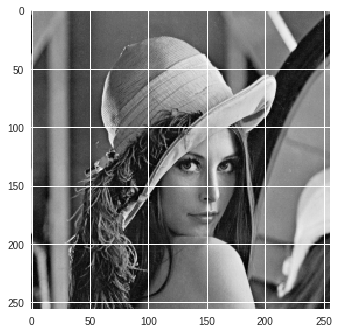

In [0]:
input_img = get_image_pixels("Lena256.bmp")

print ('Original Image :-')
plt.imshow(np.matrix(input_img),cmap='gray')
plt.show()


Image after performing Gaussian smoothing :-


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys


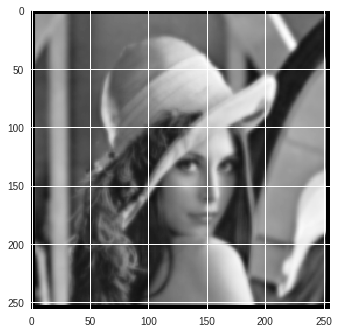

In [0]:
n = input_img.shape[0]
m = input_img.shape[1]

gaussian_mask = get_gaussian_mask()
output1 = gaussian_smoothing(input_img,gaussian_mask,n,m)
print ('Image after performing Gaussian smoothing :-')
imsave('Lena256_after_Gaussian_smoothing.bmp', np.matrix(output1))
plt.imshow(np.matrix(output1),cmap='gray')
plt.show()

Horizontal gradient image :-


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """


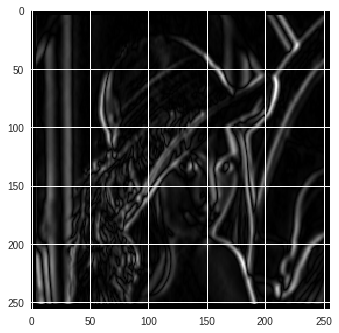

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # This is added back by InteractiveShellApp.init_path()


Vertical gradient image :-


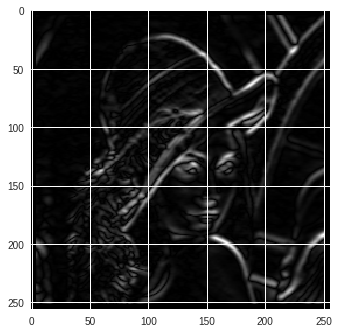

In [0]:
Gx_mask = np.matrix([[-1,0,1],[-1,0,1],[-1,0,1]])
Gy_mask = np.matrix([[1,1,1],[0,0,0],[-1,-1,-1]])

Gx, Gy = get_XY_gradients(output1,Gx_mask,Gy_mask,n,m)
imsave('Lena256_Horizontal_gradient.bmp', np.matrix(Gx))

print ('Horizontal gradient image :-')
plt.imshow(np.matrix(Gx),cmap='gray')
plt.show()

imsave('Lena256_Vertical_gradient.bmp', np.matrix(Gy))

print ('Vertical gradient image :-')
plt.imshow(np.matrix(Gy),cmap='gray')
plt.show()

Normalized edge magnitude image :-


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


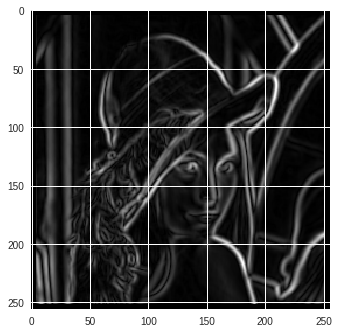

In [0]:
M, Theta = get_gradient_and_theta(Gx,Gy,n,m)
print ('Normalized edge magnitude image :-')

imsave('Lena256_Normalized_edge_magnitude.bmp', np.matrix(M))

plt.imshow(np.matrix(M),cmap='gray')
plt.show()

Normalized edge magnitude image after non-maxima suppression :-


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


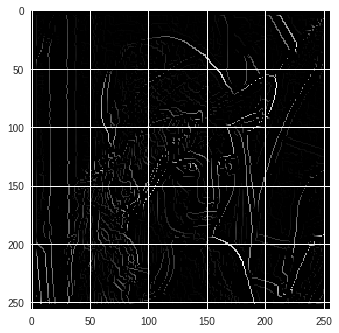

In [0]:
N = non_maxima_suppression(M,Theta,n,m)
print ('Normalized edge magnitude image after non-maxima suppression :-')

imsave('Lena256_edge_magnitude_suppressed.bmp', np.matrix(N))

plt.imshow(np.matrix(N),cmap='gray')
plt.show()

For p=10%, threshold value = 28.6725949514, number of edges detected = 1100


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """


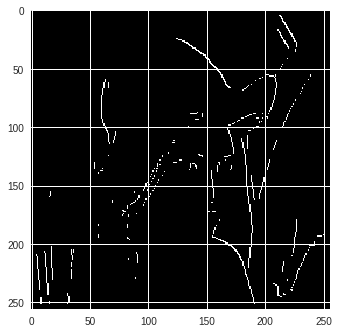

For p=30%, threshold value = 12.6283161155, number of edges detected = 3298


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # Remove the CWD from sys.path while we load stuff.


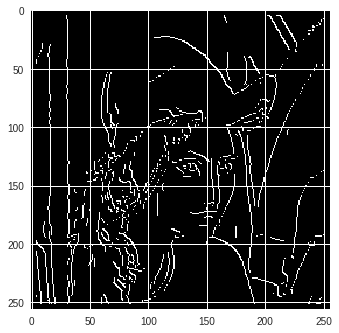

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  app.launch_new_instance()


For p=50%, threshold value = 5.33401489055, number of edges detected = 5497


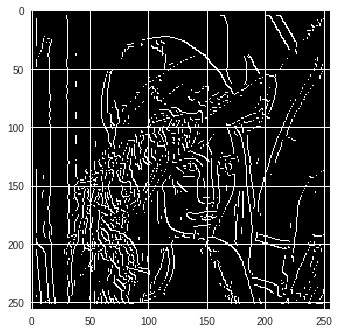

In [0]:

(op1,op2,op3),(t1,t2,t3),(edge_count1,edge_count2,edge_count3) = p_tile_thresholding(N)
print ('For p=10%, threshold value = {}, number of edges detected = {}'.format(t1,edge_count1))

imsave('Lena256_ptile_threshold_10.bmp', op1)

plt.imshow(op1,cmap='gray')
plt.show()

imsave('Lena256_ptile_threshold_30.bmp', op2)

print ('For p=30%, threshold value = {}, number of edges detected = {}'.format(t2,edge_count2))
plt.imshow(op2,cmap='gray')
plt.show()

imsave('Lena256_ptile_threshold_50.bmp', op3)

print ('For p=50%, threshold value = {}, number of edges detected = {}'.format(t3,edge_count3))
plt.imshow(op3,cmap='gray')
plt.show()



### For zebra-crossing-1.bmp image

Original Image :-


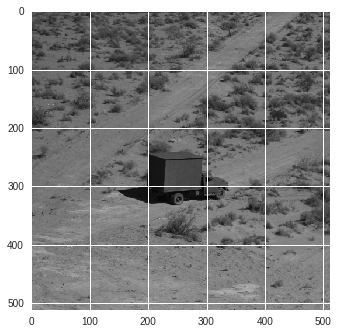

In [0]:
input_img = get_image_pixels("Truck.bmp")

print ('Original Image :-')

plt.imshow(np.matrix(input_img),cmap='gray')
plt.show()


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Image after performing Gaussian smoothing :-


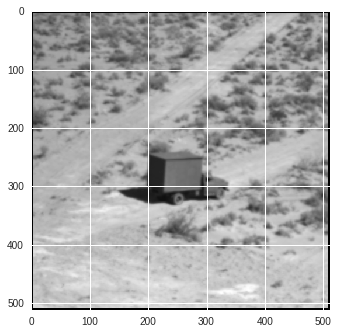

In [0]:
n = input_img.shape[0]
m = input_img.shape[1]

gaussian_mask = get_gaussian_mask()
output1 = gaussian_smoothing(input_img,gaussian_mask,n,m)
imsave('Truck_after_Gaussian_smoothing.bmp', np.matrix(output1))

print ('Image after performing Gaussian smoothing :-')

plt.imshow(np.matrix(output1),cmap='gray')
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Horizontal gradient image :-


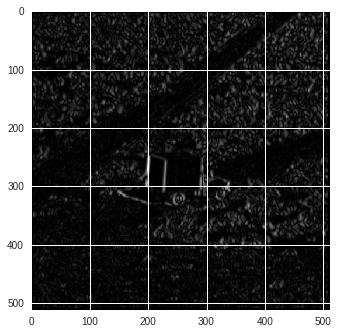

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  if sys.path[0] == '':


Vertical gradient image :-


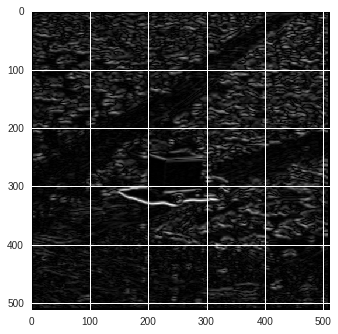

In [0]:
Gx_mask = np.matrix([[-1,0,1],[-1,0,1],[-1,0,1]])
Gy_mask = np.matrix([[1,1,1],[0,0,0],[-1,-1,-1]])

Gx, Gy = get_XY_gradients(output1,Gx_mask,Gy_mask,n,m)

imsave('Truck_horizontal_gradient.bmp', np.matrix(Gx))

print ('Horizontal gradient image :-')
plt.imshow(np.matrix(Gx),cmap='gray')
plt.show()

imsave('Truck_vertical_gradient.bmp', np.matrix(Gy))

print ('Vertical gradient image :-')
plt.imshow(np.matrix(Gy),cmap='gray')
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Normalized edge magnitude image :-


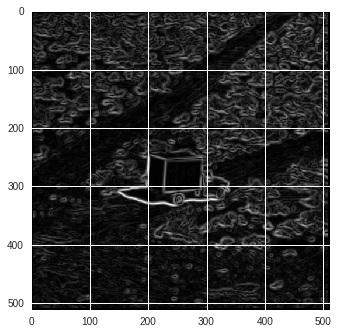

In [0]:
M, Theta = get_gradient_and_theta(Gx,Gy,n,m)

imsave('Truck_edge_magnitude.bmp', np.matrix(M))

print ('Normalized edge magnitude image :-')
plt.imshow(np.matrix(M),cmap='gray')
plt.show()

Normalized edge magnitude image after non-maxima suppression :-


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


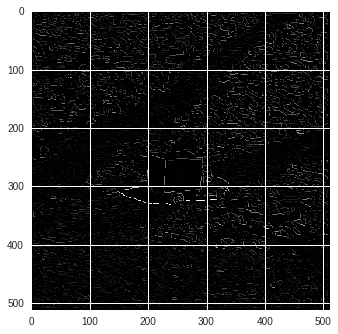

In [0]:
N = non_maxima_suppression(M,Theta,n,m)

imsave('Truck_edge_magnitude_suppressed.bmp', np.matrix(N))

print ('Normalized edge magnitude image after non-maxima suppression :-')
plt.imshow(np.matrix(N),cmap='gray')
plt.show()

For p=10%, threshold value = 11.9431819324, number of edges detected = 5668


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


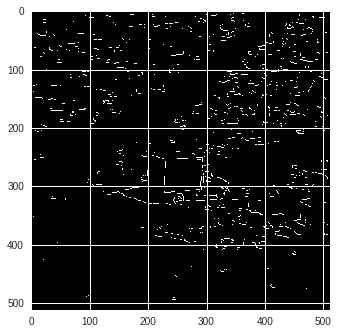

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


For p=30%, threshold value = 7.08762175106, number of edges detected = 17002


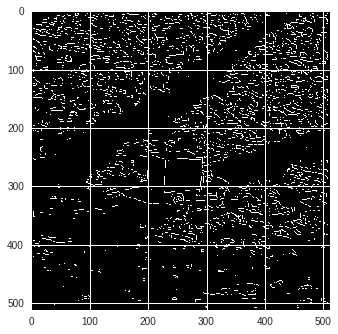

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  del sys.path[0]


For p=50%, threshold value = 4.15721990328, number of edges detected = 28336


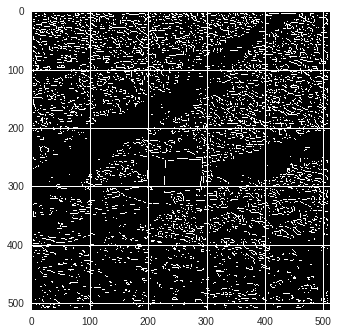

In [0]:

(op1,op2,op3),(t1,t2,t3),(edge_count1,edge_count2,edge_count3) = p_tile_thresholding(N)
imsave('Truck_ptile_threshold_10.bmp', op1)

print ('For p=10%, threshold value = {}, number of edges detected = {}'.format(t1,edge_count1))
plt.imshow(op1,cmap='gray')
plt.show()
imsave('Truck_ptile_threshold_30.bmp', op2)

print ('For p=30%, threshold value = {}, number of edges detected = {}'.format(t2,edge_count2))
plt.imshow(op2,cmap='gray')
plt.show()
imsave('Truck_ptile_threshold_50.bmp', op3)

print ('For p=50%, threshold value = {}, number of edges detected = {}'.format(t3,edge_count3))
plt.imshow(op3,cmap='gray')
plt.show()


